In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from non_linearity.environment import Particle
from scipy import signal as sn
from scipy.optimize import curve_fit

In [89]:
def autocor_0(t, omega, gamma, m= 3.368e-18):
    kb = 1.3806e-23
    T = 293
    C = 2*(gamma*kb*T/m)
    
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    T0 = C*np.exp(-gamma*t/2)*(2*Omega*np.cos(Omega*t)+gamma*np.sin(Omega*t))/(4*gamma*Omega*(omega**2))
    return T0


def autocor_perturbation(t, omega, gamma, b, tau, m= 3.368e-18):
    kb = 1.3806e-23
    T = 293
    T0 = autocor_0(t, omega, gamma, m=m)
    C = 2*(gamma*kb*T/m) 
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    mult = 12*np.exp(-gamma*t/2)/(64*(gamma**3)*(Omega**4)*(omega**6))
    part1 = np.exp(gamma*tau/2)*(8*gamma*(Omega**4)-4*(omega**2)*(gamma**2)*(Omega**2)*(t-tau))*np.cos(Omega*(t-tau))
    
    part2 = Omega*np.exp(gamma*tau/2)*(8*gamma*(Omega**2)*(omega**2)*(t-tau)+\
                                       8*(Omega**4)+4*(gamma**2)*(omega**2)+6*(gamma**2)*(Omega**2))*np.sin(Omega*(t-tau))
    part3 = np.exp(-gamma*tau/2)*(Omega**2)*(2*Omega*(gamma**2)-8*(Omega**3))*np.sin(Omega*(t+tau))
    part4 = np.exp(-gamma*tau/2)*8*gamma*(Omega**4)*np.cos(Omega*(t+tau))
    T1 = -(4*C*C*b/8)*mult*(part1+part2+part3+part4)
    return T0+T1

def theoretical_area_frac(omega, gamma, gain, delay, m=3.368e-18):
    T0 = autocor_0(0, omega, gamma, m=m)
    T1 = autocor_perturbation(0, omega, gamma, gain, delay, m=m)
    return T1/T0

In [133]:
omega = 2*np.pi*81.5e3
T = 2*np.pi/omega
t = np.arange(0, 500*T, T/1000)
N = t.shape[0]
delta_t = np.diff(t)[0]

In [134]:
100*T

0.001226993865030675

In [135]:
(T/4)/delta_t

250.0

In [136]:
gamma = 13000
env = Particle(omega, gamma, radius=73e-9)

In [137]:
def linear_force(states, t, **kwargs):
    return kwargs['gain']*states[0]


def cubic_force(states, t, **kwargs):
    return kwargs['gain']*np.power(states[0],3)


def sine_force(states, t, **kwargs):
    return kwargs['gain']*np.sin(2*np.pi*kwargs['freq']*t)

In [138]:
def simulation(env, t, force=None, delay=40, std_detection=1, **kwargs):
    states = np.array([[0],[0.]])
    N = t.shape[0]
    new_states = np.zeros((N,2))     
    for i in range(t.shape[0]):
        new_states[i,:] = states[:,0]
        if delay <= i:
            if not force:
                control = 0
            else: 
                control = force(new_states[i-delay,:], t[i], **kwargs)
        else:
            control = 0
        states = env.step(states, control=control, delta_t=delta_t)
    return new_states

In [139]:
M = 1
states = np.zeros((N, M))
for i in tqdm(range(M)):
    states[:,i] = simulation(env, t)[:,0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.61s/it]


In [140]:
M = 5
cubic_states = np.zeros((N, M))
for i in tqdm(range(M)):
    cubic_states[:,i] = simulation(env, t, force=cubic_force, delay=0, gain=(3e5*(env.zp_x**3)/env.zp_p))[:,0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:20<00:00, 16.18s/it]


In [142]:
M = 10
damped_delays = {i: [] for i in range(100, 1010, 100)}
for delay in damped_delays.keys():
    print(delay)
    damped_states = np.zeros((N, M)) 
    for i in tqdm(range(M)):
        damped_states[:,i] = simulation(env, t, force=cubic_force, delay=delay, gain=(3e5*(env.zp_x**3)/env.zp_p))[:,0]
    damped_delays[delay] = damped_states

100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:40<00:00, 16.01s/it]


200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:36<00:00, 15.62s/it]


300


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:35<00:00, 15.53s/it]


400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:39<00:00, 15.90s/it]


500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:36<00:00, 15.70s/it]


600


 20%|█████████████████████                                                                                    | 2/10 [00:33<02:13, 16.75s/it]/tmp/ipykernel_27931/1684829236.py:6: RuntimeWarning: overflow encountered in power
  return kwargs['gain']*np.power(states[0],3)
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/non_linearity-0.0.1-py3.8.egg/non_linearity/environment/particle.py:27: RuntimeWarning: invalid value encountered in multiply
  state_dot = np.matmul(self.A,states) + self.B*control
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:43<00:00, 16.37s/it]


700


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.73s/it]


800


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.56s/it]


900


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.82s/it]


1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:42<00:00, 16.21s/it]


In [143]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[1]):
        freq, pxx = sn.welch(traces[:,0], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[0]/2))
        pxxs.append(pxx)
    return freq, np.array(pxxs).mean(axis=0)

(0.01, 624771.10682886)

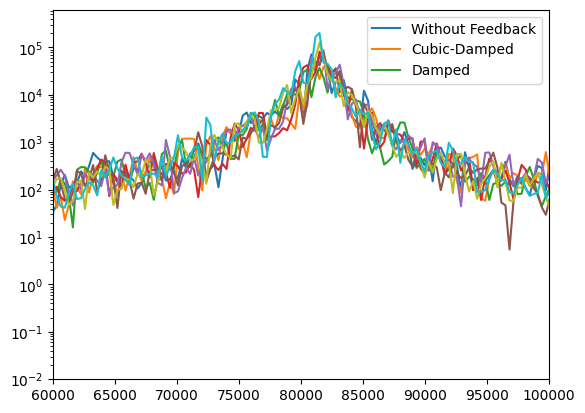

In [146]:
#freq, pxx = psd(states, delta_t)
freq, pxx = psd(states, delta_t)
freq_c, cubic_pxx = psd(cubic_states, delta_t)
damped_pxxs = {i: []for i in range(100, 1010, 100)}
for i in damped_pxxs.keys():
    freq_d, damped_pxx = psd(damped_delays[i], delta_t)
    damped_pxxs[i] = {'freq': freq_d, 'psd': damped_pxx}
    plt.semilogy(freq_d, damped_pxx)
#plt.semilogy(freq, pxx)
#plt.semilogy(freq, pxx)
#plt.semilogy(freq_c, cubic_pxx)
#plt.semilogy(freq_d, damped_pxx)
plt.legend(['Without Feedback','Cubic-Damped', 'Damped'])
plt.xlim([6e4, 1.0e5])
plt.ylim([1e-2, 4*max(pxx)])

In [147]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [148]:
delays, areas = [], []
for key in damped_pxxs.keys():
    areas.append(damped_pxxs[key]['psd'].sum()/pxx.sum())
    delays.append(key*delta_t)

In [149]:
theory_delays = np.linspace(0, 2*T, 100)
areas_t = theoretical_area_frac(env.__omega__, env.__gamma__, -3e5/env._m_, theory_delays, m=env._m_)

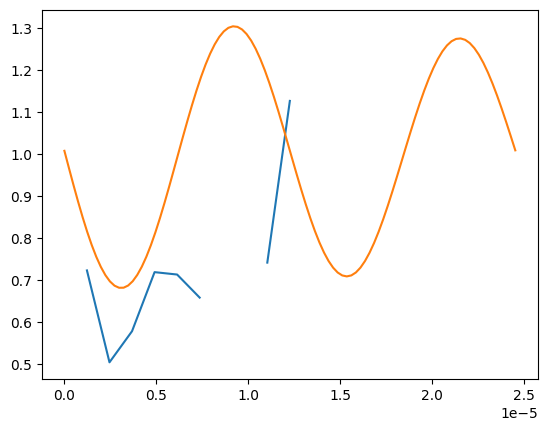

In [150]:
plt.plot(delays, areas)
plt.plot(theory_delays, areas_t)
#damped_pxxs.keys()

In [ ]:
plt.plot(damped_states)